<a href="https://colab.research.google.com/github/jecampagne/demo-hopfield-rbm-networks/blob/main/demo_rbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("current device is",device)

current device is cpu


In [3]:
class RBM():
    def __init__(self, num_visible, num_hidden, k=1,
                 learning_rate=1e-2, momentum_coefficient=0.5, weight_decay=1e-4,
                 device="cuda"):
        """ Simple Restricted Boltzman Machine
            Original code from  GabrielBianconi/pytorch-rbm github repository
            num_visible: number of visible neurons
            num_hidden : number of hidden neurons
            k          : the number of contrastive divergence approximation (so called CD-k)
            learning_rate, momentum_coefficient, weight_decay are learning algoithm parameters
            nb. no bias terms
        """
        self.num_visible = num_visible
        self.num_hidden  = num_hidden
        self.k = k
        self.learning_rate = learning_rate
        self.momentum_coefficient = momentum_coefficient
        self.weight_decay = weight_decay
        self.device = device

        #initialisation
        self.weights = torch.randn(num_visible, num_hidden) * 0.1

        self.weights_momentum     = torch.zeros(num_visible, num_hidden)
        #self.visible_bias_momentum = torch.zeros(num_visible)
        #self.hidden_bias_momentum  = torch.zeros(num_hidden)

        # put to device
        self.weights      = self.weights.to(device)
        #self.visible_bias = self.visible_bias.to(device)
        #self.hidden_bias  = self.hidden_bias.to(device)

        self.weights_momentum = self.weights_momentum.to(device)
        #self.visible_bias_momentum = self.visible_bias_momentum.to(device)
        #self.hidden_bias_momentum = self.hidden_bias_momentum.to(device)

    def load_weights(self, fname):
        self.weights = torch.tensor(np.load(fname)).to(device)

    def sample_hidden(self, visible_probabilities):
        hidden_activations = torch.matmul(visible_probabilities, self.weights) #+ self.hidden_bias
        hidden_probabilities = torch.sigmoid(hidden_activations)
        return hidden_probabilities

    def sample_visible(self, hidden_probabilities):
        visible_activations = torch.matmul(hidden_probabilities, self.weights.t()) #+ self.visible_bias
        visible_probabilities = torch.sigmoid(visible_activations)
        return visible_probabilities

    def contrastive_divergence(self, input_data):
        # Positive weight update factor
        positive_hidden_probabilities = self.sample_hidden(input_data)
        positive_hidden_activations = (positive_hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()
        positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)

        # Negative  weight update factor
        hidden_activations = positive_hidden_activations

        for step in range(self.k):
            visible_probabilities = self.sample_visible(hidden_activations)
            hidden_probabilities = self.sample_hidden(visible_probabilities)
            hidden_activations = (hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        negative_associations = torch.matmul(negative_visible_probabilities.t(), negative_hidden_probabilities)

        # Update parameters
        self.weights_momentum *= self.momentum_coefficient
        self.weights_momentum += (positive_associations - negative_associations)

        #self.visible_bias_momentum *= self.momentum_coefficient
        #self.visible_bias_momentum += torch.sum(input_data - negative_visible_probabilities, dim=0)

        #self.hidden_bias_momentum *= self.momentum_coefficient
        #self.hidden_bias_momentum += torch.sum(positive_hidden_probabilities - negative_hidden_probabilities, dim=0)

        batch_size = input_data.size(0)

        self.weights += self.weights_momentum * self.learning_rate / batch_size
        #self.visible_bias += self.visible_bias_momentum * self.learning_rate / batch_size
        #self.hidden_bias += self.hidden_bias_momentum * self.learning_rate / batch_size

        self.weights -= self.weights * self.weight_decay  # L2 weight decay

        # Compute reconstruction error
        error = torch.sum((input_data - negative_visible_probabilities)**2)

        return error

    def _random_probabilities(self, num):
        random_probabilities = torch.rand(num).to(self.device)
        return random_probabilities

In [4]:
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [5]:
########## CONFIGURATION ##########
BATCH_SIZE = 64
VISIBLE_UNITS = 784  # 28 x 28 images
HIDDEN_UNITS = 140
CD_K = 1
EPOCHS = 100

DATA_FOLDER = 'data/mnist'

In [6]:
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, k=CD_K,device=device)
try:
  rbm.load_weights("rbm_weights.npy")
except Exception as e:
    print(e)

In [7]:
########## LOADING DATASET ##########
print('Loading dataset...')

train_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Loading dataset...
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 139317119.02it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 26017116.37it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 48391979.77it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2974785.88it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [102]:
########## TRAINING RBM ##########
print('Training RBM...')

all_epochs = []
for epoch in range(EPOCHS):
    epoch_error = 0.0

    for batch, _ in train_loader:
        batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
        batch = batch.to(device)
        batch_error = rbm.contrastive_divergence(batch)

        epoch_error += batch_error

    all_epochs.append(epoch_error)
    print('Epoch Error (epoch=%d): %.4f' % (epoch, epoch_error))



Training RBM...
Dbg RBM weight mtx shape: torch.Size([784, 140])
Epoch Error (epoch=0): 2052812.0000
Epoch Error (epoch=1): 1312108.3750
Epoch Error (epoch=2): 1157923.2500
Epoch Error (epoch=3): 1080078.3750
Epoch Error (epoch=4): 1033309.5625
Epoch Error (epoch=5): 998843.6875
Epoch Error (epoch=6): 974272.6250
Epoch Error (epoch=7): 956007.2500
Epoch Error (epoch=8): 940017.1250
Epoch Error (epoch=9): 927573.8125
Epoch Error (epoch=10): 917240.6250
Epoch Error (epoch=11): 907992.8750
Epoch Error (epoch=12): 901531.3125
Epoch Error (epoch=13): 894359.6875
Epoch Error (epoch=14): 888542.8750
Epoch Error (epoch=15): 883138.2500
Epoch Error (epoch=16): 878674.8750
Epoch Error (epoch=17): 873538.6875
Epoch Error (epoch=18): 868937.1875
Epoch Error (epoch=19): 865649.8125
Epoch Error (epoch=20): 862575.8125
Epoch Error (epoch=21): 859320.1875
Epoch Error (epoch=22): 856296.3125
Epoch Error (epoch=23): 853227.4375
Epoch Error (epoch=24): 850612.0625
Epoch Error (epoch=25): 847836.1875
Epoc

In [8]:
########## EXTRACT FEATURES ##########
print('Extracting features...')

train_features = np.zeros((len(train_dataset), HIDDEN_UNITS))
train_labels = np.zeros(len(train_dataset))
test_features = np.zeros((len(test_dataset), HIDDEN_UNITS))
test_labels = np.zeros(len(test_dataset))

for i, (batch, labels) in enumerate(train_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    batch = batch.to(device)

    train_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    train_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

for i, (batch, labels) in enumerate(test_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data
    batch = batch.to(device)

    test_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    test_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

Extracting features...


In [104]:
test_features.shape

(10000, 140)

In [13]:
weights = rbm.weights.detach().cpu().numpy()

In [106]:
np.save("rbm_weights.npy",rbm.weights.detach().cpu().numpy())

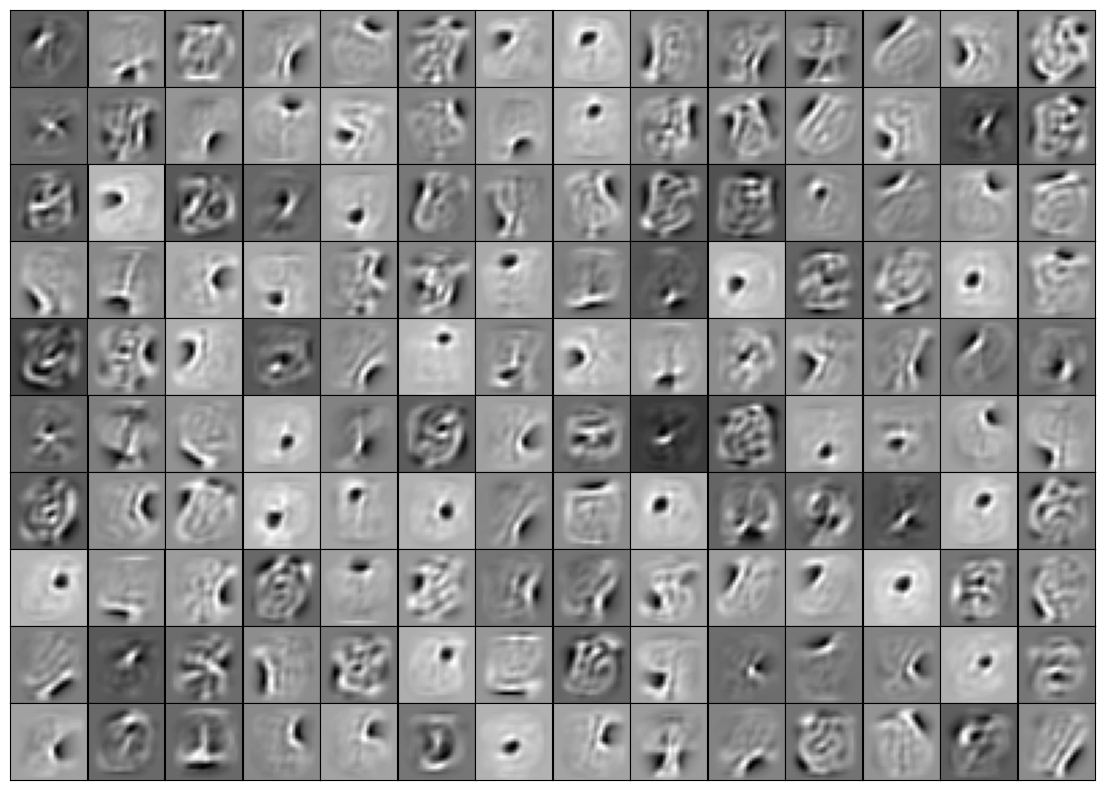

In [56]:
np.random.seed(12345)
index = np.random.randint(0,HIDDEN_UNITS+1,49)
index = np.sort(index)

fig, axs=plt.subplots(10,14,figsize=(14,10))
axs = axs.ravel();
for i,ax in zip(np.arange(140),axs):
  ax.imshow(weights[:,i].reshape((28,28)),cmap="gray")
  ax.set_xticks([])
  ax.set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
#fig.tight_layout()
fig.savefig("weight_mtx.pdf")

In [9]:
########## CLASSIFICATION ##########
print('Classifying...')

clf = LogisticRegression(max_iter=500)
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)

print('Result: %d/%d' % (sum(predictions == test_labels), test_labels.shape[0]))

Classifying...
Result: 9476/10000


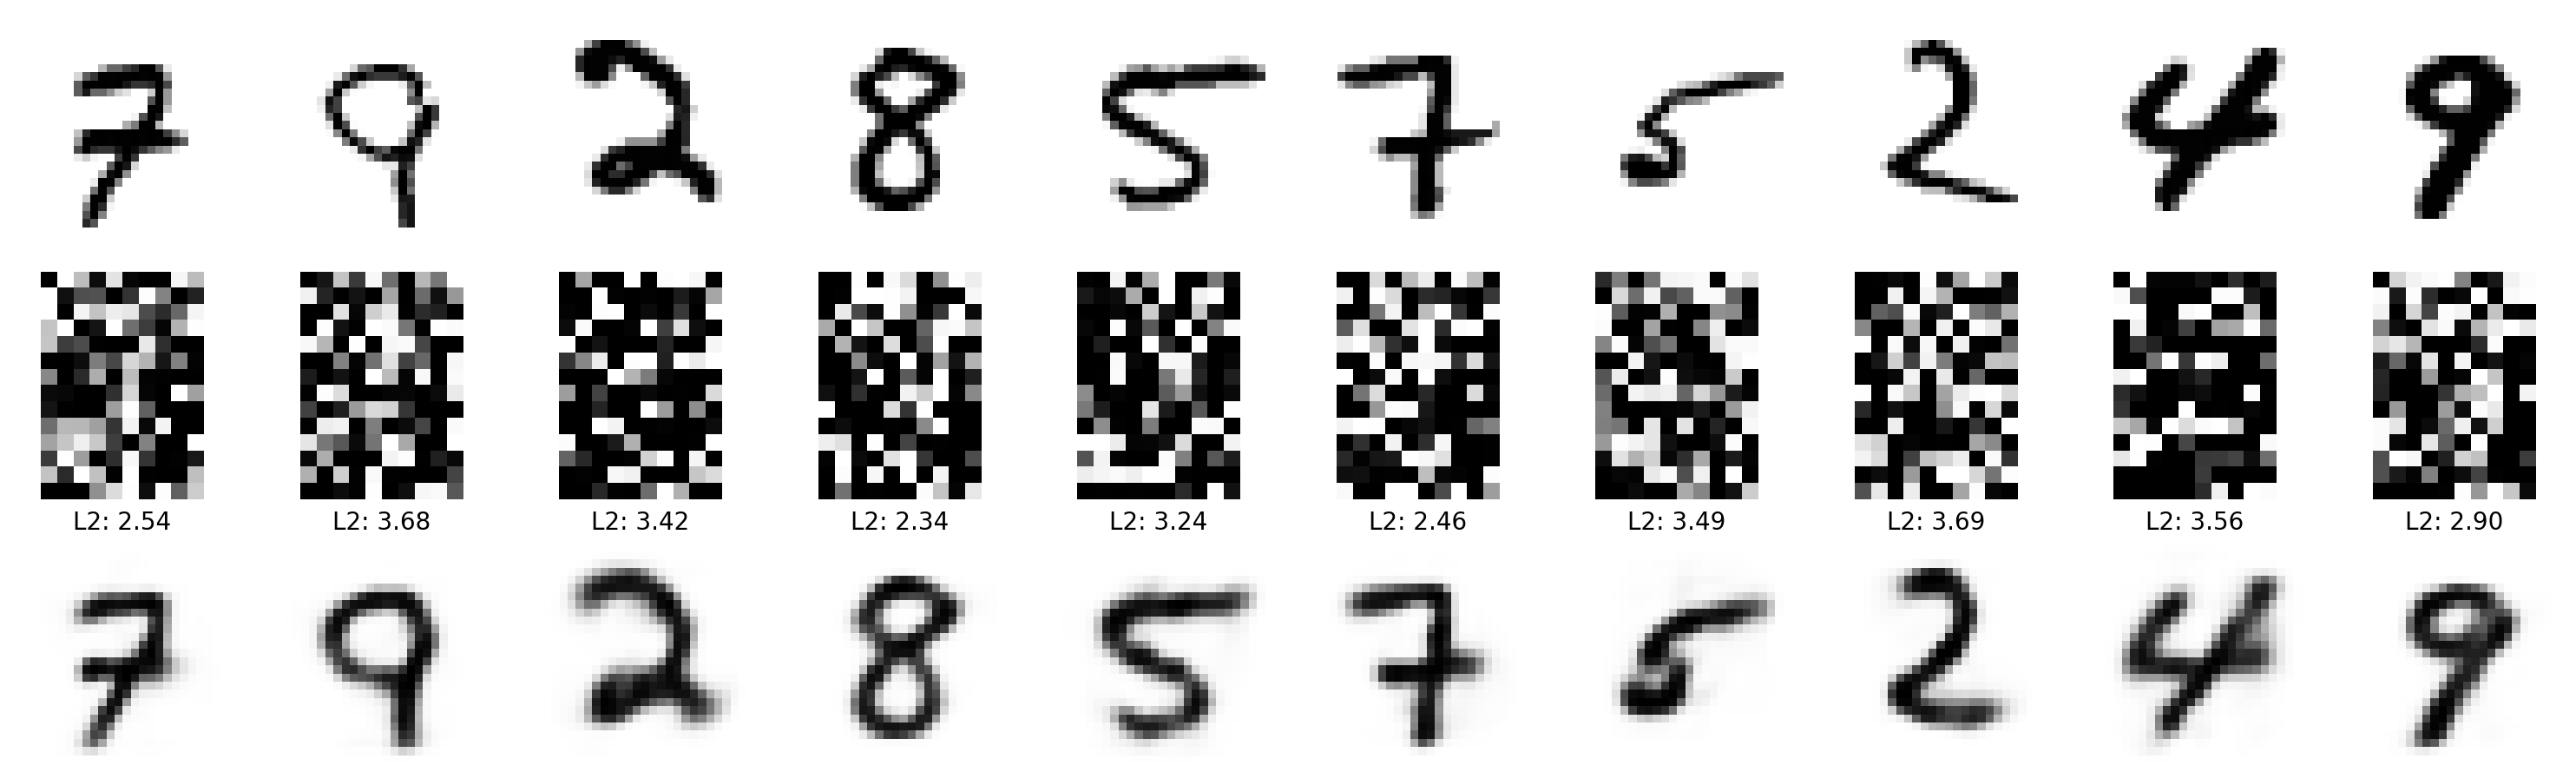

In [40]:
np.random.seed(1)
index = np.random.randint(0,len(test_dataset)+1,10)
index = np.sort(index)

fig, axs=plt.subplots(3,10,figsize=(10*3,3*3))
for i in range(len(index)):
  img_orig,label = test_dataset[index[i]]
  img = img_orig.view(1, VISIBLE_UNITS)
  img = img.to(device)
  hidden = rbm.sample_hidden(img)
  #print(label, clf.predict(hidden))
  visib  = rbm.sample_visible(hidden)

  hidden = hidden.detach().cpu()
  visib  = visib.detach().cpu()

  l2norm = (img_orig[0].flatten()-visib.flatten()).norm(p=2)


  axs[0,i].imshow(img_orig[0],cmap="gray_r")
#  axs[0,i].set_title(f"label: {label}",fontsize=30)
  axs[1,i].imshow(hidden[0].reshape((14,10)),cmap='gray')
  axs[2,i].imshow(visib[0].reshape((28,28)),cmap='gray_r')
  axs[2,i].set_title(f"L2: {l2norm:.2f}",fontsize=20)

for ax in axs.ravel():
  ax.set_xticks([])
  ax.set_yticks([])
  ax.axis('off')

fig.tight_layout()

fig.savefig("digit_reco_1.pdf")

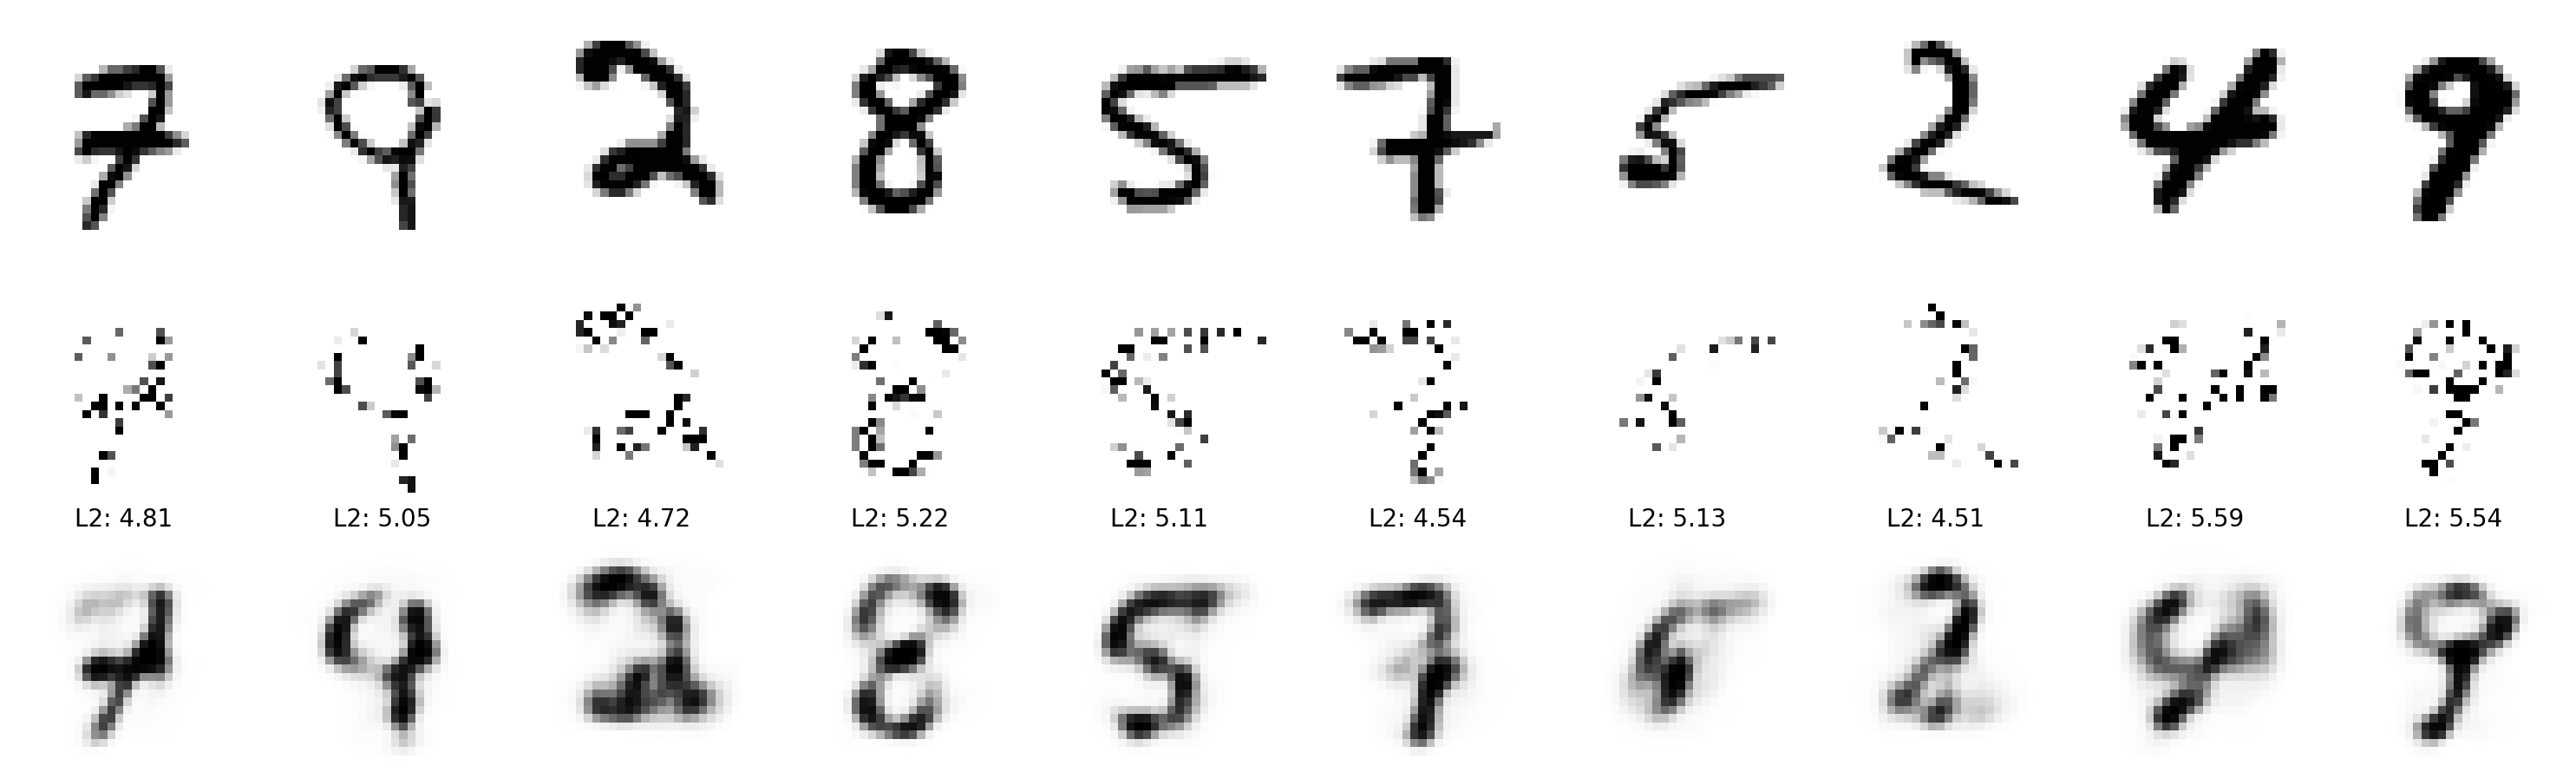

In [39]:
np.random.seed(1)
index = np.random.randint(0,len(test_dataset)+1,10)
index = np.sort(index)


fig, axs=plt.subplots(3,10,figsize=(10*3,3*3))
for i in range(len(index)):
  img_orig,label = test_dataset[index[i]]
  img_ = img_orig.view(1, VISIBLE_UNITS).clone().detach()
  mask = np.random.binomial(1, 0.3, size=(1,VISIBLE_UNITS))
  mask = mask.astype(np.float32)
  img_ *= mask
  img = img_.to(device)
  hidden = rbm.sample_hidden(img)
  #print(label, clf.predict(hidden))
  visib  = rbm.sample_visible(hidden)

  hidden = hidden.detach().cpu()
  visib  = visib.detach().cpu()

  l2norm = (img_orig[0].flatten()-visib.flatten()).norm(p=2)

  axs[0,i].imshow(img_orig[0],cmap="gray_r")
  axs[1,i].imshow(img_[0].reshape((28,28)),cmap="gray_r")
  axs[2,i].imshow(visib[0].reshape((28,28)),cmap='gray_r')
  axs[2,i].set_title(f"L2: {l2norm:.2f}",fontsize=20)

for ax in axs.ravel():
  ax.set_xticks([])
  ax.set_yticks([])
  ax.axis('off')

fig.tight_layout()
fig.savefig("digit_reco_2.pdf")

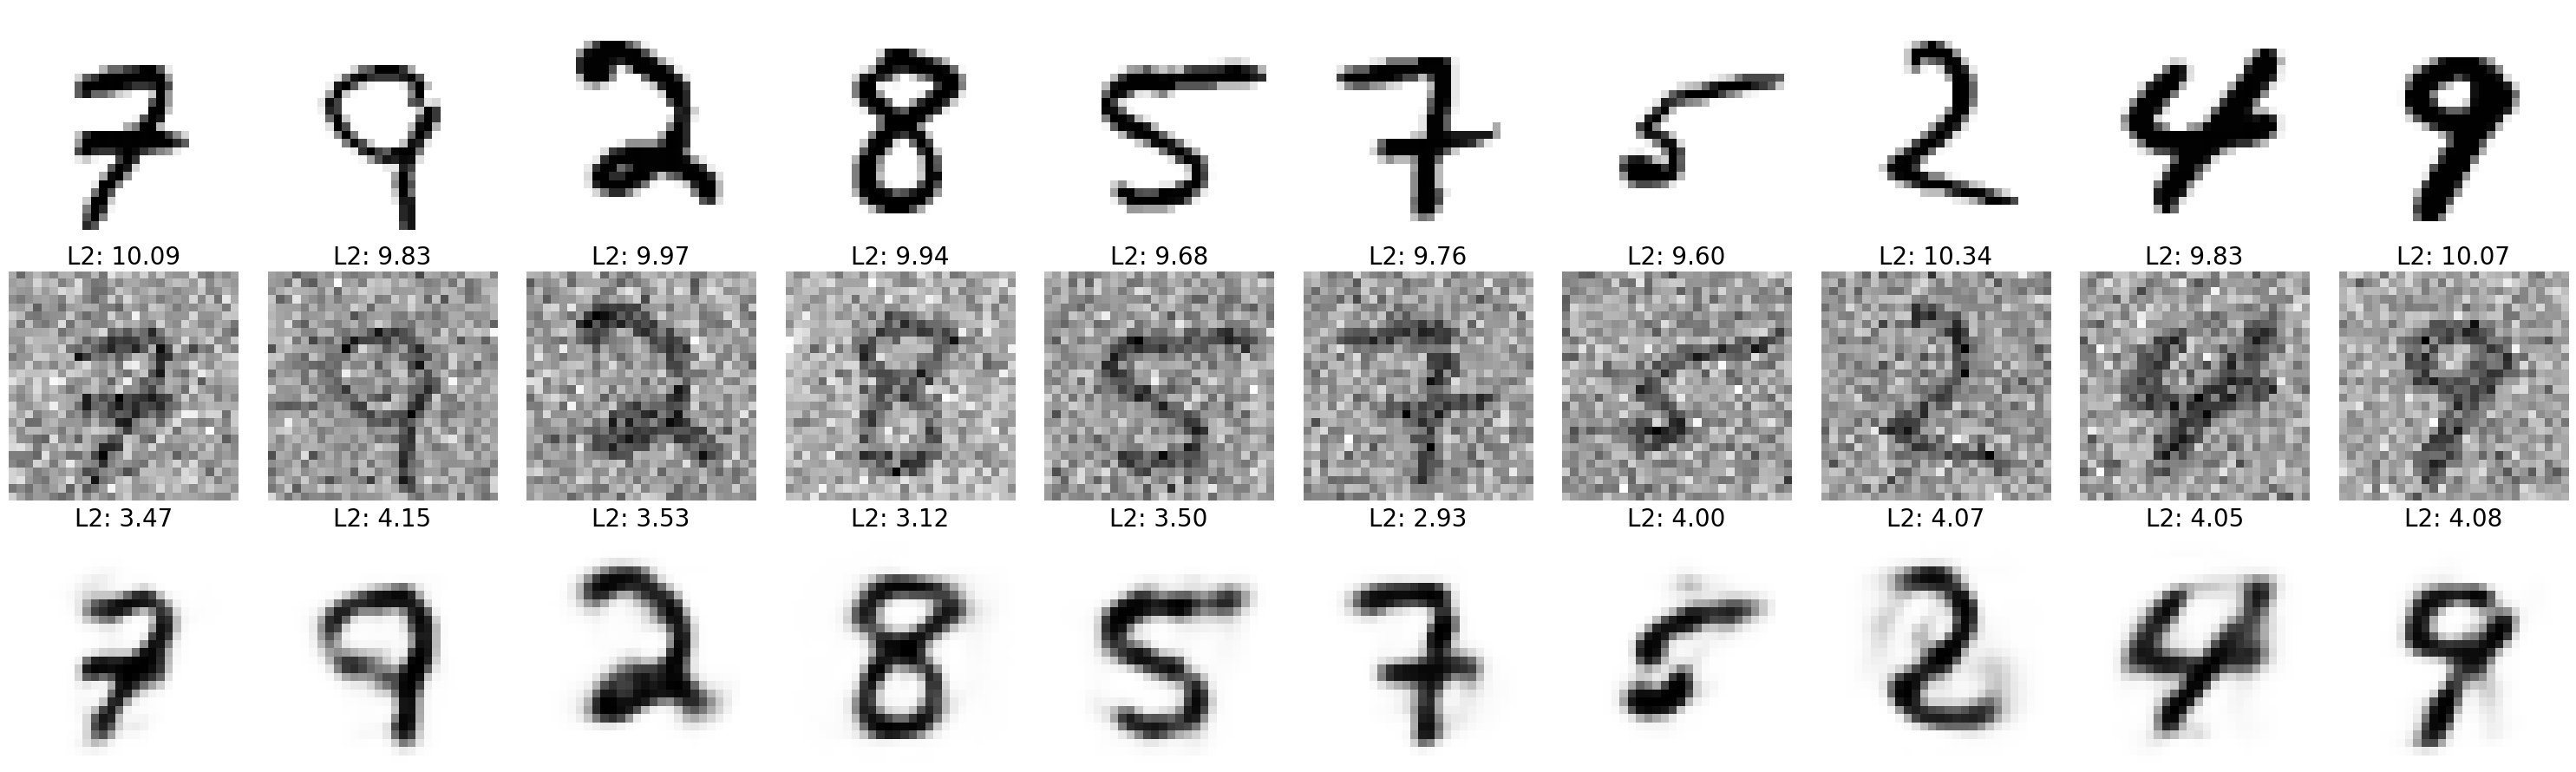

In [52]:
np.random.seed(1)
index = np.random.randint(0,len(test_dataset)+1,10)
index = np.sort(index)

fig, axs=plt.subplots(3,10,figsize=(10*3,3*3))
for i in range(len(index)):
  img_orig,label = test_dataset[index[i]]
  img_ = img_orig.view(1, VISIBLE_UNITS).clone().detach()  # values in [0,1]
  noise = torch.randn(1, VISIBLE_UNITS) * np.sqrt(100/VISIBLE_UNITS)
  img_ += noise
  img = img_.to(device)
  hidden = rbm.sample_hidden(img)
  visib  = rbm.sample_visible(hidden)

  hidden = hidden.detach().cpu()
  visib  = visib.detach().cpu()

  l2norm_n = (noise.flatten()).norm(p=2)
  l2norm = (img_orig[0].flatten()-visib.flatten()).norm(p=2)


  axs[0,i].imshow(img_orig[0],cmap="gray_r")
  axs[1,i].imshow(img_[0].reshape((28,28)),cmap="gray_r")
  axs[1,i].set_title(f"L2: {l2norm_n:.2f}",fontsize=20)
  axs[2,i].imshow(visib[0].reshape((28,28)),cmap='gray_r')
  axs[2,i].set_title(f"L2: {l2norm:.2f}",fontsize=20)

for ax in axs.ravel():
  ax.set_xticks([])
  ax.set_yticks([])
  ax.axis('off')

fig.tight_layout()
fig.savefig("digit_reco_3.pdf")

In [74]:
test_dataset[index[i]][0].shape

torch.Size([1, 28, 28])

In [78]:
type(test_features[index[i]].reshape(1,-1))

numpy.ndarray

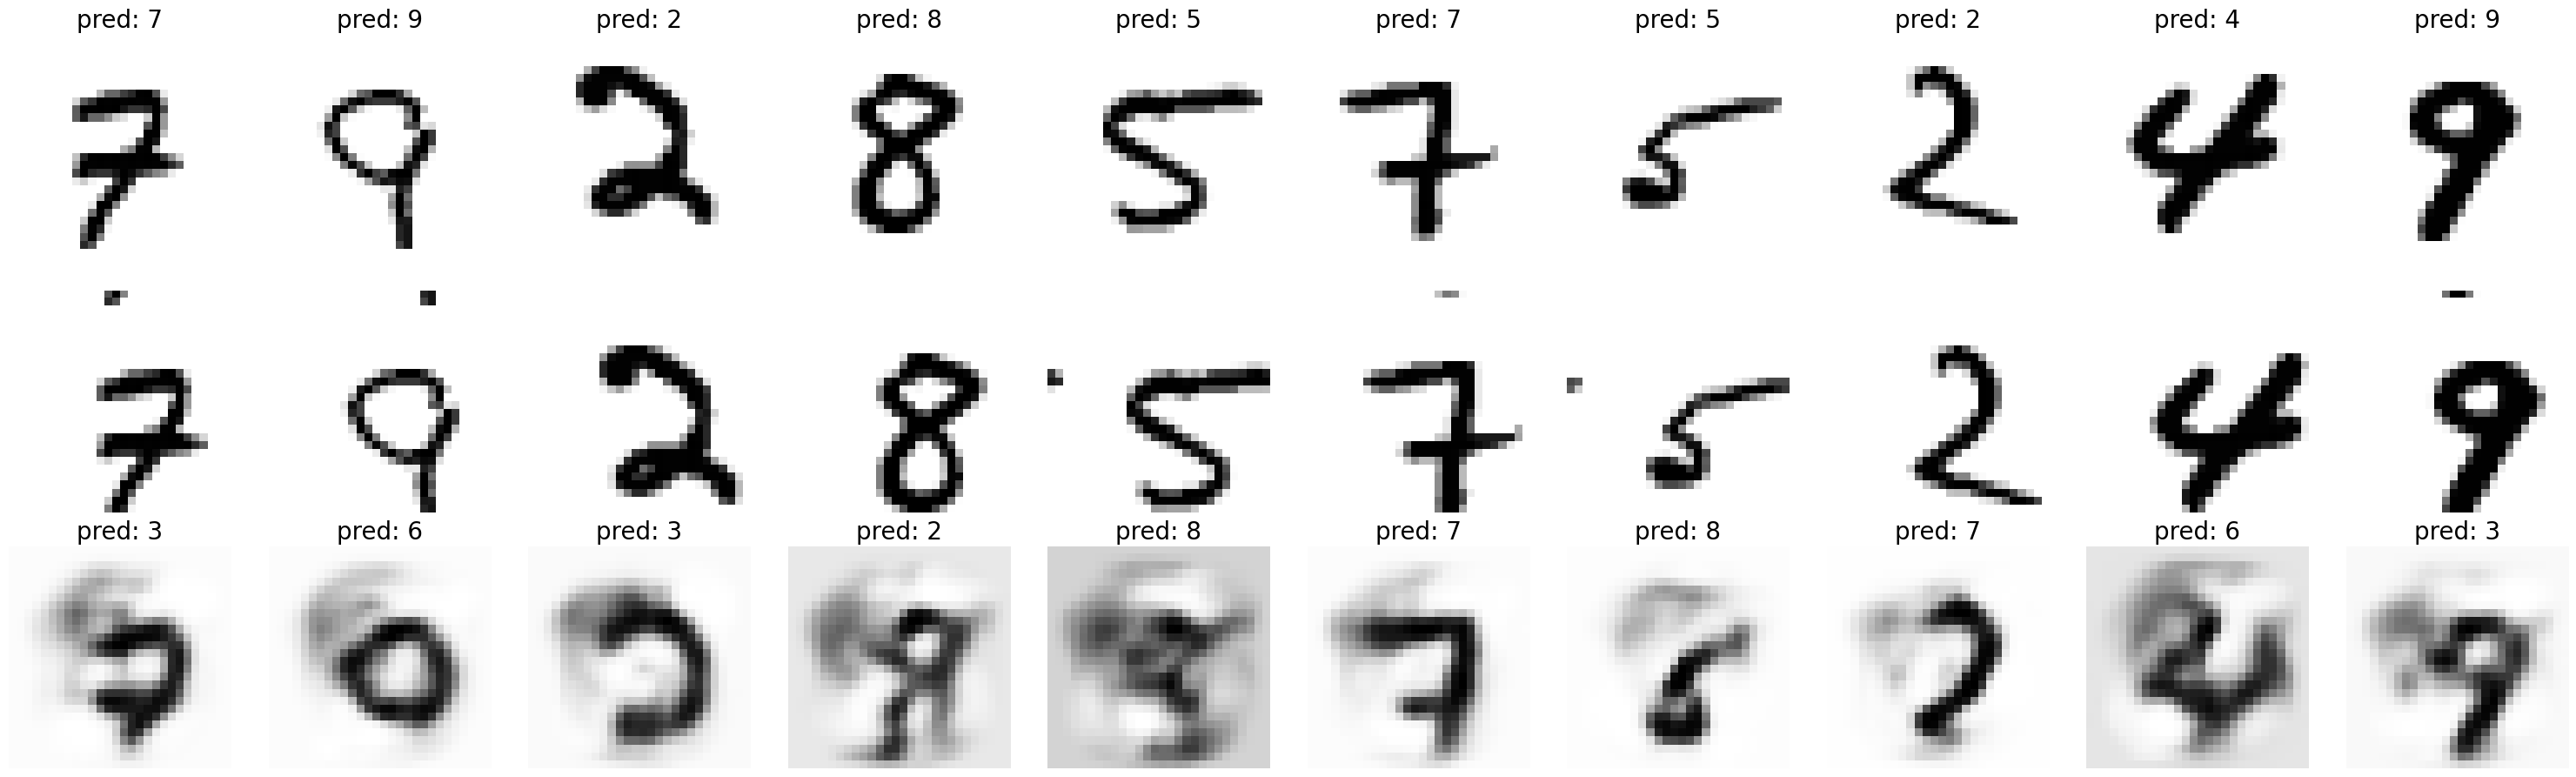

In [15]:
np.random.seed(1)
index = np.random.randint(0,len(test_dataset)+1,10)
index = np.sort(index)

fig, axs=plt.subplots(3,10,figsize=(10*3,3*3))
for i in range(len(index)):
  img_orig,label = test_dataset[index[i]]
  img_orig_shifted = torch.roll(img_orig, shifts=(3,3), dims=(1,2))
  img_ = img_orig_shifted.view(1, VISIBLE_UNITS).clone().detach()  # values in [0,1]
  img = img_.to(device)
  hidden = rbm.sample_hidden(img)
  visib  = rbm.sample_visible(hidden)

  hidden = hidden.detach().cpu()
  visib  = visib.detach().cpu()

  prodict_orig = clf.predict(test_features[index[i]].reshape(1,-1))

  predictions = clf.predict(hidden)

  axs[0,i].imshow(img_orig[0],cmap="gray_r")
  axs[0,i].set_title(f"pred: {int(prodict_orig[0])}",fontsize=20)
  axs[1,i].imshow(img_orig_shifted[0],cmap="gray_r")
  axs[2,i].imshow(visib[0].reshape((28,28)),cmap='gray_r')
  axs[2,i].set_title(f"pred: {int(predictions[0])}",fontsize=20)

for ax in axs.ravel():
  ax.set_xticks([])
  ax.set_yticks([])
  ax.axis('off')

fig.tight_layout()
fig.savefig("digit_reco_4.pdf")